In [1]:
import omnitool
from omnitool.literature_values import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
'''We'll use the asteroseismic data from Yu et al. 2018'''
#Read in Jie Yu
print('Reading in Yu+2018')
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
yu18_1 = pd.read_csv(sfile, sep='|')
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
yu18_2 = pd.read_csv(sfile, sep='|')
yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
yu18.rename(columns={'KICID':'KIC',
                    'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1_x':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2_y':'[Fe/H]_err',
                    'err.1_y':'logg_err',
                    'err.3_y':'M_err',
                    'err.4_y':'R_err'},inplace=True) #For consistency

Reading in Yu+2018


In [3]:
'''First, lets get our asteroseismic values'''
#Calling the scaling relations class
SC = omnitool.scalings(yu18, yu18.numax, yu18.dnu, yu18.Teff,\
                          _numax_err = yu18.numax_err,\
                          _dnu_err = yu18.dnu_err,\
                          _Teff_err = yu18.Teff_err)

In [4]:
'''Now lets pull out all the values we can calculate'''
yu18['R'] = SC.get_radius()/Rsol
yu18['R_err'] = SC.get_radius_err()/Rsol
yu18['M'] = SC.get_mass()/Msol
yu18['M_err'] = SC.get_mass_err()/Msol
yu18['logg'] = SC.get_logg()
yu18['logg_err'] = SC.get_logg_err()
yu18['L'] = SC.get_luminosity()/Lsol
yu18['L_err'] = SC.get_luminosity_err()/Lsol
yu18['Mbol'] = SC.get_bolmag()
yu18['Mbol_err'] = SC.get_bolmag_err()

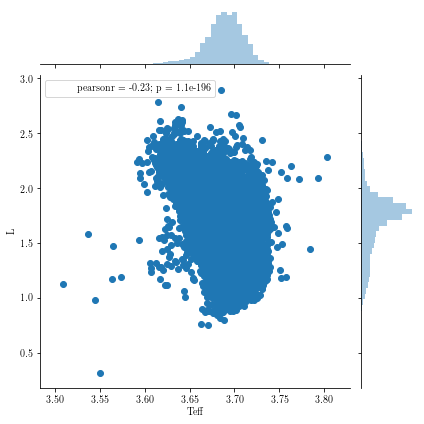

In [5]:
'''Lets plot a quick distribution of points on a HR diagram.'''
sns.jointplot(np.log10(yu18.Teff), np.log10(yu18.L))
plt.show()

In [6]:
'''Now lets say we want to find the K and H band magnitudes of
these stars asteroseismically.
For this, we need an inverse bolometric correction.'''
#For the bolomteric correction, we need the total metallicity Z
yu18['Z'] = Zsol * 10**yu18['[Fe/H]']

#Now we initialise the class using these values
get_bc = omnitool.bolometric_correction(yu18.Teff.values,\
                                       yu18.logg.values,\
                                       yu18.Z.values)

In [7]:
'''We now want to calculate the bolometric correction for
these stars in the K, H and J bands'''
KsBC = get_bc(band='Ks')
HBC = get_bc(band='H')
JBC = get_bc(band='J')

100%|██████████| 16094/16094 [00:09<00:00, 1678.58it/s]


In [8]:
'''Using this value & the bolometric magnitude we can make the inverse bolometric 
correction'''
MKs_ast = yu18.Mbol.values - KsBC
MH_ast = yu18.Mbol.values - HBC
MJ_ast = yu18.Mbol.values - JBC

In [9]:
'''If we want to be extra thorough, we propagate the assumed error
on the bolometric correction

For now this is just guesstimated at 0.02 per Huber et al. 2017, BUT
it should be noted that they use a different method of obtaining the BC'''

M_ast_err = np.sqrt(yu18.Mbol_err.values**2 + err_bc**2)

'''Note that this error is the same regardless of passband'''

'Note that this error is the same regardless of passband'

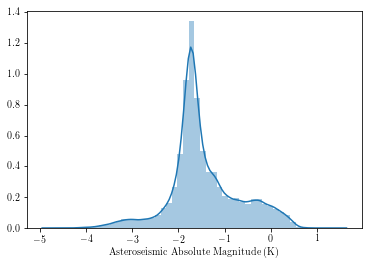

Median in K: -1.6353740088095476


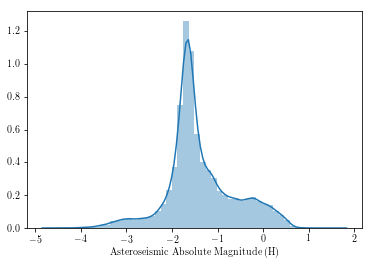

Median in H: -1.5612212010660622


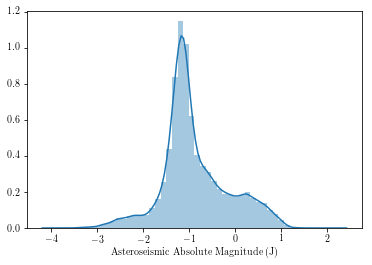

Median in J: -1.055250347987501


In [10]:
'''Lets plot a distribution of the results...'''
sns.distplot(MKs_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (K)')
plt.show()
print('Median in K: '+str(np.median(MKs_ast)))

sns.distplot(MH_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (H)')
plt.show()
print('Median in H: '+str(np.median(MH_ast)))

sns.distplot(MJ_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (J)')
plt.show()
print('Median in J: '+str(np.median(MJ_ast)))


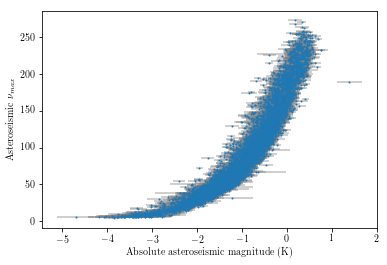

In [11]:
'''Lets do a quick plot to illustrate the errors on the data... We'll plot Core He Burning stars only for clarity.'''
sel = yu18.stage == 1

fig, ax = plt.subplots()
ax.scatter(MKs_ast[sel],yu18.numax[sel],s=1,zorder=1001)
ax.errorbar(MKs_ast[sel],yu18.numax[sel],xerr=M_ast_err[sel], alpha=.5, fmt='none', c='grey',zorder=1000)
ax.set_xlabel('Absolute asteroseismic magnitude (K)')
ax.set_ylabel(r"Asteroseismic $\nu_{\text{max}}$")
plt.show()